In [31]:
import numpy as np
import matplotlib.pyplot as plt 
import random
import math
import sklearn.model_selection 
from sklearn import datasets

np.random.seed(1)

# Функции предобработки данных

In [3]:
def map(func, iterable):
    result = []
    for item in iterable:
        result.append(func(item))
    return result

def minibatch(data, batch_size):
    batches = []
    num_batches = len(data) // batch_size
    for i in range(num_batches):
        start_index = i * batch_size
        end_index = start_index + batch_size
        batch_data = data[start_index:end_index]
        batches.append(batch_data)
    if len(data) % batch_size != 0:
        batches.append(data[num_batches*batch_size:])
    return batches

def shuffle(data):
    random.shuffle(data)
    return data

def train_test_split(arr, part=0.8):
    index = len(arr) * part
    index = math.ceil(index)
    first_half = arr[:index]
    second_half = arr[index:]
    return first_half, second_half

def plot_dataset(suptitle, features, labels):
    fig, ax = plt.subplots(1, 1)
    fig.suptitle(suptitle, fontsize = 16)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')

    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    fig.show()

# Функции активации

In [4]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy
    
class Arctan:
    def forward(self,x):
        y = np.arctan(x)
        self.x = x
        return y
    def backward(self, dy):
        return dy / (self.x**2 + 1)
    
class Softplus:
    def forward(self, x):
        y = np.log(1 + np.exp(x))
        self.x = x
        return y
    def backward(self, dy):
        return dy / (1 + np.exp(-self.x))    
    
class Sigmoid:
    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        self.y = y
        return y
    def backward(self, dy):
        return self.y * (1 - self.y) * dy

# Функции ошибок

In [5]:
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        tmp = dlog_softmax / self.p
        return tmp

class MAELoss:
    def forward(self, p, y):
        self.p = p
        self.y = y
        self.p_of_y = p[np.arange(len(y)), y]
        return np.mean(np.abs(self.y - self.p_of_y))
    def backward(self, loss):
        dmse = np.zeros_like(self.p)
        dmse[np.arange(len(self.y)), self.y] -= np.sign(self.y - self.p_of_y) / len(self.y)
        return dmse

class MSELoss:
    def forward(self, p, y):
        self.p = p
        self.y = y
        self.p_of_y = p[np.arange(len(y)), y]
        return np.mean(np.square(y - self.p_of_y))
    def backward(self, loss):
        dmse = np.zeros_like(self.p)
        dmse[np.arange(len(self.y)), self.y] -= 2 * (self.y - self.p_of_y)
        return dmse / len(self.y)

class BinaryCrossEntropyLoss:
    def forward(self, p, y):
        self.p = p
        self.y = y
        self.p_of_y = p[np.arange(len(y)), y]
        loss = y * np.log(self.p_of_y) + (1 - y) * np.log(1 - self.p_of_y)
        return -loss.mean()
    def backward(self, loss):
        dbinaryloss = np.zeros_like(self.p)
        dbinaryloss[np.arange(len(self.y)), self.y] -= 1.0 / len(self.y) * (self.y / self.p_of_y - (1 - self.y) / (1 - self.p_of_y))
        return dbinaryloss

# Функции оптимизации

In [6]:
def sgd(X, y, lr=0.01, num_epochs=10, batch_size=32):
    w = np.zeros(X.shape[1])
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for epoch in range(num_epochs):
        np.random.shuffle(indices)
        for i in range(0, X.shape[0], batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            gradient = np.dot(X_batch.T, (np.dot(X_batch, w) - y_batch)) / X_batch.shape[0]
            w -= lr * gradient
    return w

def momentum_sgd(X, y, lr=0.01, num_epochs=10, batch_size=32, momentum=0.9):
    w = np.zeros(X.shape[1])
    v = np.zeros(X.shape[1])
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for epoch in range(num_epochs):
        np.random.shuffle(indices)
        for i in range(0, X.shape[0], batch_size):
            batch_indices = indices[i:i+batch_size]
            X_batch = X[batch_indices]
            y_batch = y[batch_indices]
            gradient = np.dot(X_batch.T, (np.dot(X_batch, w) - y_batch)) / X_batch.shape[0]
            v = momentum * v - lr * gradient
            w += v
    return w

def gradient_clipping(grads, clip_norm):
    norm = np.linalg.norm(grads)
    if norm > clip_norm:
        clipped_grads = grads * (clip_norm / norm)
    else:
        clipped_grads = grads
    return clipped_grads


# Класс нейросети

In [7]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class Net:
    def __init__(self, layers, loss=CrossEntropyLoss()):
        self.layers = []
        for layer in layers:
            self.layers.append(layer)
        self.loss = loss   
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

    def train(self, x_train, y_train, loss=CrossEntropyLoss(), learning_rate=0.01):
        x_batches = minibatch(x_train, 4)
        y_batches = minibatch(y_train, 4)
        for xb, yb in zip(x_batches, y_batches):
            p = self.forward(xb)
            l = loss.forward(p, yb)
            dp = loss.backward(l)
            dx = self.backward(dp)
            self.update(learning_rate)

    def predict(self, x):
        return self.forward(x)       
    
    def get_loss_and_accuracy(self, x, y):
        predicted = self.forward(x)
        l = self.loss.forward(predicted, y)
        pred = np.argmax(predicted, axis=1)  
        acc = (pred==y).mean()
        return l, acc          

# Примеры использования 
## Классификация


C:\Users\leyhi\AppData\Local\Temp\ipykernel_13936\29844292.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


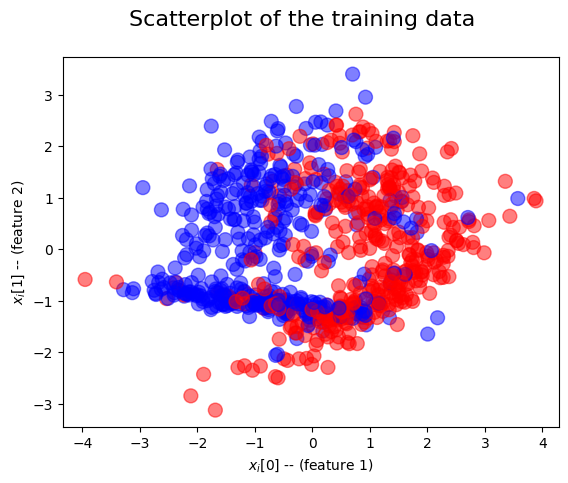

Initial loss=0.7649286860166958, accuracy=0.65375: 
Final loss=0.5422282869718842, accuracy=0.7475: 
Test loss=0.5403039187475607, accuracy=0.78: 


In [11]:
net = Net([Linear(2, 2), Softmax()], loss=CrossEntropyLoss())

n = 1000
X, Y = datasets.make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.2)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

train_x, test_x = train_test_split(X, 0.8)
train_y, test_y = train_test_split(Y, 0.8)

plot_dataset('Scatterplot of the training data', train_x, train_y)
plt.show()

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_and_accuracy(train_x, train_y)))
net.train(train_x, train_y)
print("Final loss={}, accuracy={}: ".format(*net.get_loss_and_accuracy(train_x, train_y)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_and_accuracy(test_x,test_y)))        

## Iris датасет

In [9]:
iris = datasets.load_iris()

In [117]:
net = Net([Linear(4, 3), Softmax()], loss=CrossEntropyLoss())

iris_data = shuffle(list(zip(iris.data, iris.target)))
feauters_labels = [[x for x, y in iris_data],
                   [y for x, y in iris_data]]
train_x, test_x = train_test_split(feauters_labels[0], 0.8)
train_y, test_y = train_test_split(feauters_labels[1], 0.8)

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_and_accuracy(train_x, train_y)))
net.train(train_x, train_y)
print("Final loss={}, accuracy={}: ".format(*net.get_loss_and_accuracy(train_x, train_y)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_and_accuracy(test_x,test_y)))        

Initial loss=1.1131339845056278, accuracy=0.35: 
Final loss=0.8156806147448137, accuracy=0.7166666666666667: 
Test loss=0.8385205849637679, accuracy=0.7: 


## Нелинейная регрессия

In [67]:
net = Net([Linear(4, 3), Tanh(), Linear(3, 3), Softmax()], loss=MAELoss())

x = np.arange(-6.0, 6.0, 0.1)
y = 1*(x**3) + 2*(x**2) + 1*x + 3
y_noise = 2 * np.random.normal(size=x.size)
y_data = y + y_noise

x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x, y_data, test_size=0.3, random_state=101)

print("Initial loss={}, accuracy={}: ".format(*net.get_loss_and_accuracy(train_x, train_y)))
net.train(train_x, train_y)
print("Final loss={}, accuracy={}: ".format(*net.get_loss_and_accuracy(train_x, train_y)))
print("Test loss={}, accuracy={}: ".format(*net.get_loss_and_accuracy(test_x,test_y))) 

Initial loss=0.8570553837958808, accuracy=0.7083333333333334: 
Final loss=0.9064335523629715, accuracy=0.7666666666666667: 
Test loss=0.8740884340440171, accuracy=0.7: 
